In [410]:
!sudo apt-get install -y fonts-nanum;
!sudo fc-cache -fv;
!rm ~/.cache/matplotlib -rf;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [411]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import seaborn as sns
import missingno as msno

import warnings
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.misc import derivative

plt.style.use("default")
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
mpl.rc('font', family='NanumBarunGothic')
mpl.rc('axes', unicode_minus=False)



from google.colab import files
files.upload();

Saving vgames2.csv to vgames2 (11).csv


In [358]:
#1. 지역에 따라서 선호하는 게임장르가 다를까?
#2. 연도별 게임의 트렌드가 있을까?
#3. 출고량의 높은 게임에 대한 분석 및 시각화 프로세스
# 결론 : 다음분기에는 어떤 게임을 설계해야하는지 제시



*   데이터 탐색
*   -전처리



In [412]:
df = pd.read_csv('vgames2.csv') # 한글파일일때
df

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...,...
16593,16594,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,16595,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,16596,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,16597,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [413]:
print(df.duplicated().sum())#중복치 확인
df.isnull().sum()#결측치 확인

0


Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [414]:
df.info()#데이터 형태 분석
#출고량의 값이 obj로 되어있다. 확인 해보니 -M,-K로 구성

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


In [415]:
sales_cols = df.columns[-4:]

for col in sales_cols:
    for i, r in enumerate(df[col]):
        if 'M' in df[col][i]:
            r1 = float(r.replace('M', ''))*(10**6)
            df.at[i, col] = r1
        else:
            r1 = float(r.replace('K', ''))*(10**3)
            df.at[i, col] = r1
    df[col] = pd.to_numeric(df[col])

In [416]:
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

In [417]:
df["Total_Sales"] = df.NA_Sales + df.EU_Sales + df.JP_Sales + df.Other_Sales

In [419]:
df.drop(df.columns[0], axis = 1, inplace = True)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40.0,0.0,0.0,0.0,40.0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170.0,0.0,0.0,10.0,180.0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,20.0,0.0,20.0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40.0,0.0,0.0,0.0,40.0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120.0,90.0,0.0,40.0,250.0
...,...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,150.0,40.0,0.0,10.0,200.0
16237,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,10.0,0.0,0.0,0.0,10.0
16238,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,440.0,190.0,30.0,130.0,790.0
16239,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,50.0,50.0,250.0,30.0,380.0


In [420]:
df.dtypes

Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
Total_Sales    float64
dtype: object

*   출고량의 값이 obj로 되어있다. 확인 해보니 -M-K등으로 표기됨
*   Year의 값에 NAN 값이 포함되어있고 정식으로 발매 안된 것들의 정확한 연도를 모름
*   Publisher에 N/A가 포함. 윈도우에 직접 등록되어있었거나, 맥 앱스토에만 등록되어있어던 경우가 있다항목 추가
*   Genre : 공백으로 되어있고, 이경우 단종된 경우도 있다.



*   Year의 경우 결측값을 다른값으로 대체 할 수 없다고 생각했기 때문에 제거하기로 결정
*   Genre의 경우 공백으로 되어있고, 단종된 경우도 있고 수가 적기 때문에 제거하기로 결정
*   Publisher에 N/A가 포함. 윈도우에 직접 등록되어있었거나, 맥 앱스토에만 등록되어있어던 경우가 있다 수도 적어서 제거

# 1.   플랫폼 따라서 판매량이 다를까?

In [421]:
df['Platform'].value_counts()

DS      2127
PS2     2121
PS3     1299
Wii     1284
X360    1231
PSP     1193
PS      1185
PC       935
XB       799
GBA      784
GC       541
3DS      498
PSV      409
PS4      335
N64      313
SNES     239
XOne     212
SAT      173
WiiU     143
2600     115
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: Platform, dtype: int64

In [422]:
 df["Platform_Groups"] = np.where(df.Platform == "PC", "PC", \
                       np.where((df.Platform == "3DS") | (df.Platform == "DS") | (df.Platform == "GB") | \
                               (df.Platform == "GBA") | (df.Platform == "GG") | (df.Platform == "PSP") |  \
                               (df.Platform == "PSV") | (df.Platform == "WS"), "Portable", "Console"))
 df['Platform_Groups'].head

<bound method NDFrame.head of 0        Portable
1         Console
2        Portable
3        Portable
4         Console
           ...   
16236     Console
16237    Portable
16238     Console
16239    Portable
16240     Console
Name: Platform_Groups, Length: 16241, dtype: object>

Platform에 따른 전세계 출고량 비교

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

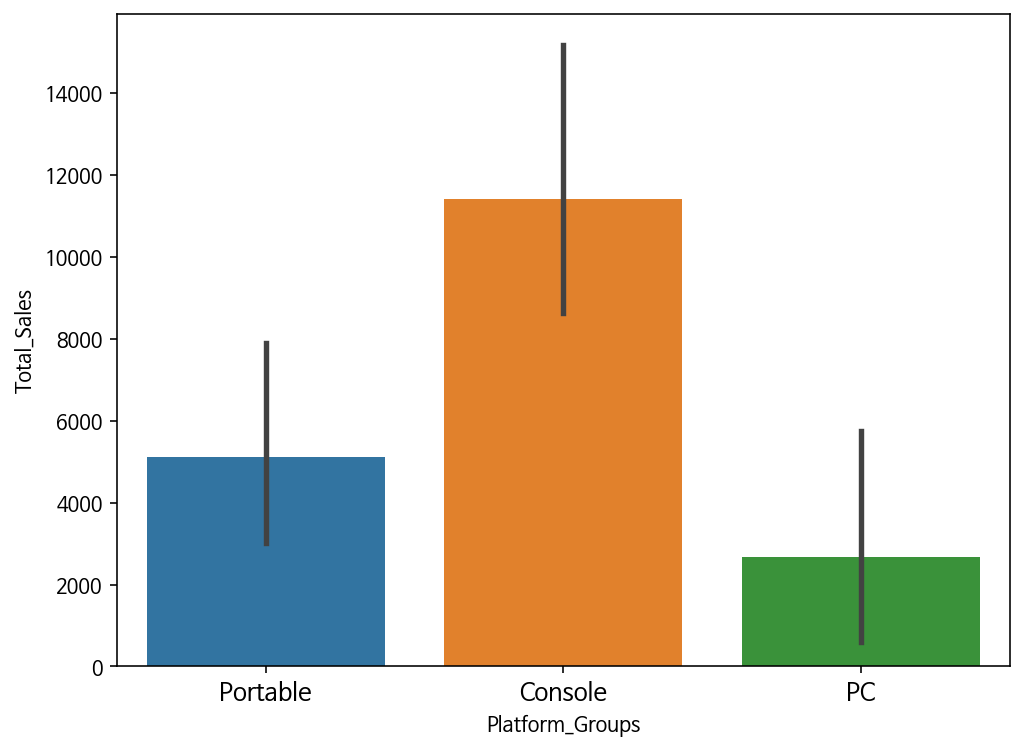

In [425]:
f, ax = plt.subplots(1,1, figsize=(8, 6))
sns.barplot(x = 'Platform_Groups', y='Total_Sales', data= df)
ax.set_ylabel('Total_Sales')
plt.xticks(fontsize=12)

콘솔게임의 전세게 판매량이 제일 많다.

Text(0.5, 0, ' ')

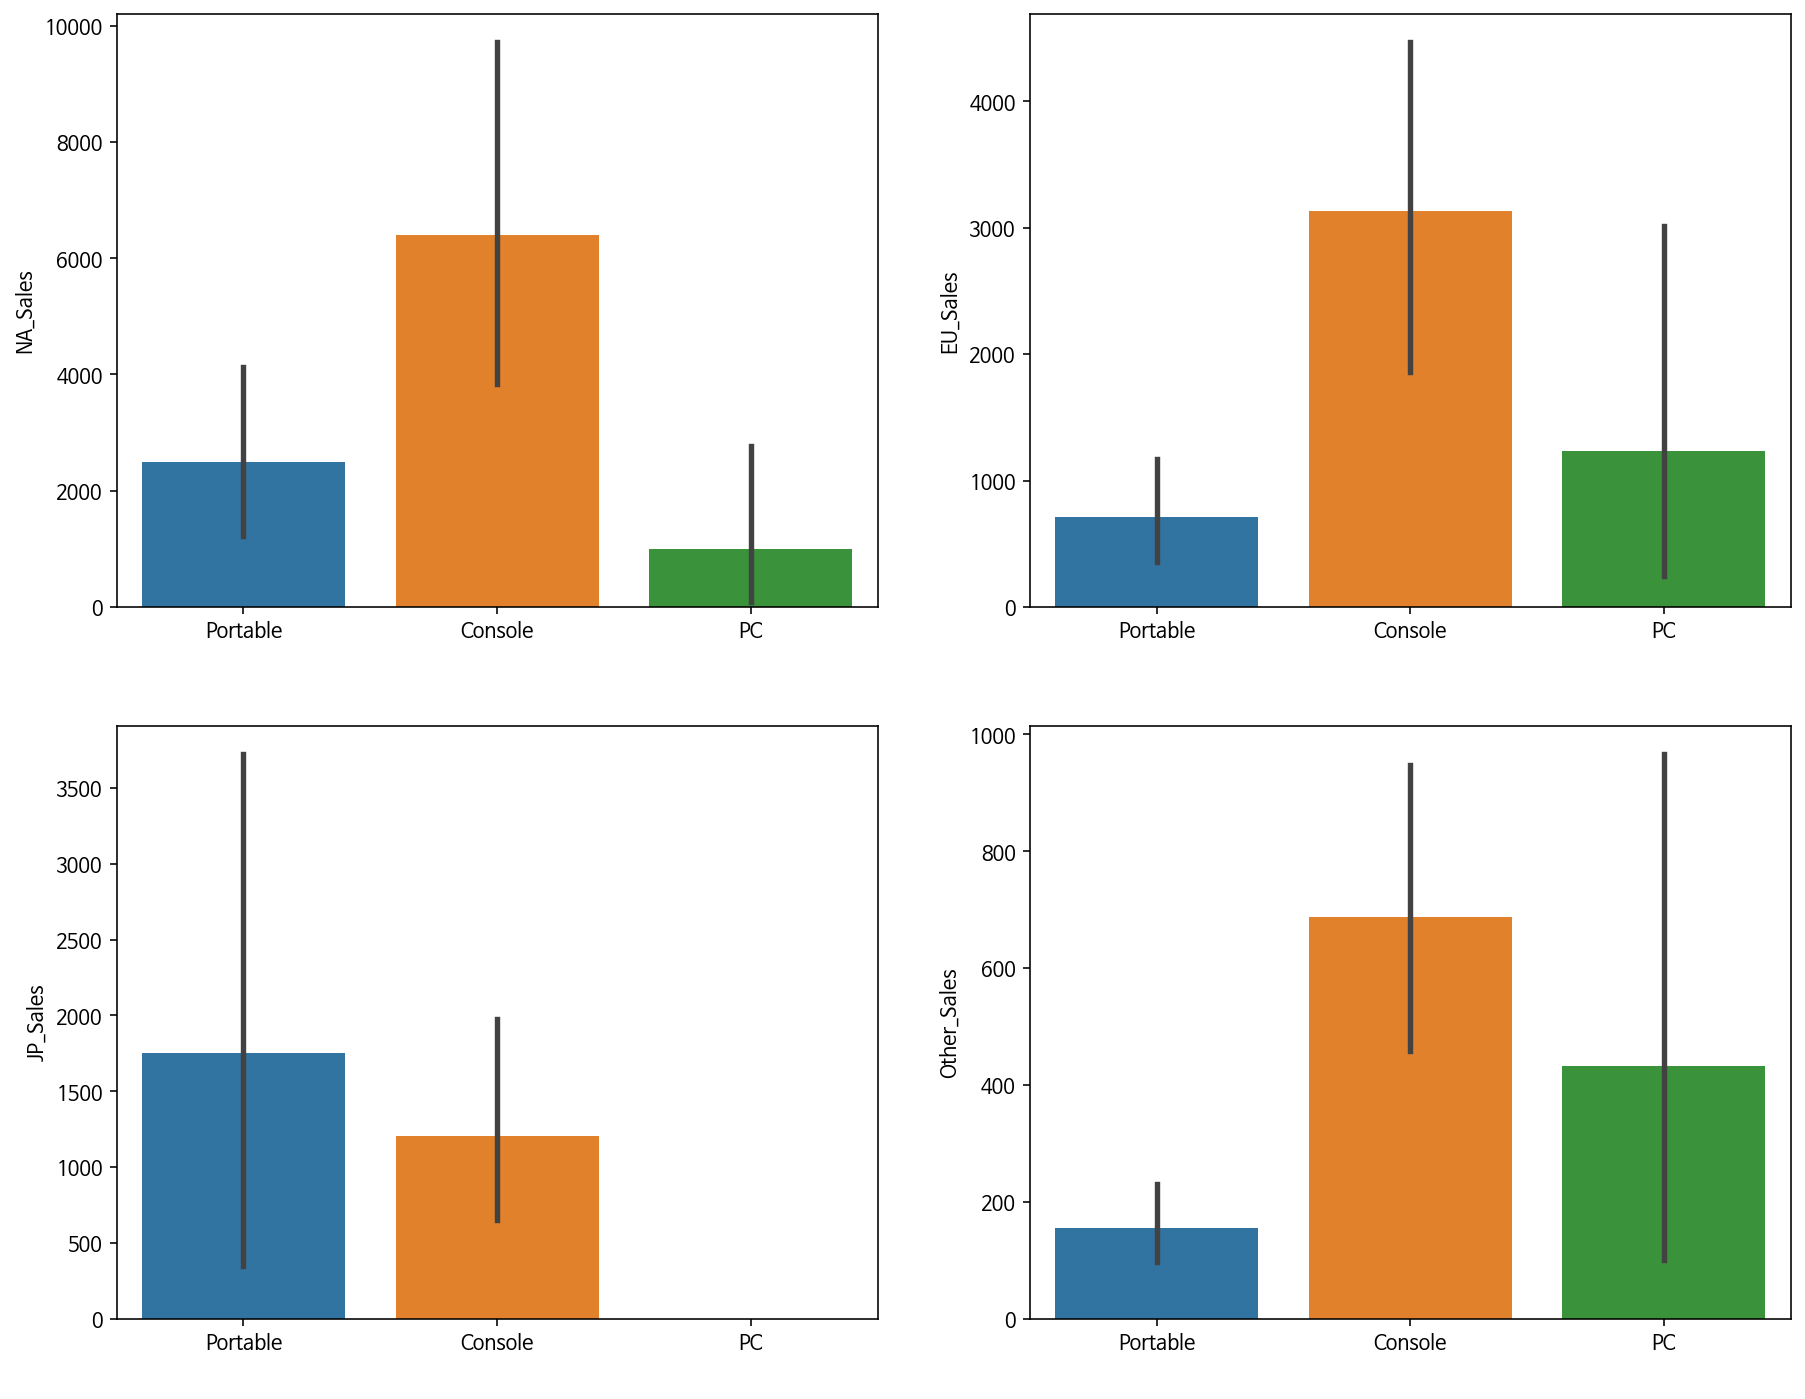

In [426]:
# Platform에 따른 각 지역 출고량 비교
f, ax = plt.subplots(2,2, figsize=(15, 12))
sns.barplot(x = 'Platform_Groups', y='NA_Sales', data=df, ax=ax[0,0])
ax[0,0].set_ylabel('NA_Sales')
ax[0,0].set_xlabel(' ')


sns.barplot(x = 'Platform_Groups', y='EU_Sales', data=df, ax=ax[0,1])
ax[0,1].set_ylabel('EU_Sales')
ax[0,1].set_xlabel(' ')


sns.barplot(x = 'Platform_Groups', y='JP_Sales', data=df, ax=ax[1,0])
ax[1,0].set_ylabel('JP_Sales')
ax[1,0].set_xlabel(' ')


sns.barplot(x = 'Platform_Groups', y='Other_Sales', data=df, ax=ax[1,1])
ax[1,1].set_ylabel('Other_Sales')
ax[1,1].set_xlabel(' ')




*   북미 지역과 유럽,기타 지역의 경우 콘솔 게임의 판매량이 높다
*   일본은 휴대용기기게임의 판매량이 높다
*   전체적인 판매량은 북미 지역이 제일 많다.


# 2.   지역에 따라서 선호하는 게임장르가 다를까?



In [429]:
# 판매량의 K와 M 문자열 처리
sales = df.columns[-4:]
sales

Index(['Other_Sales', 'Total_Sales', 'Platform_Groups', 'Multiplatform'], dtype='object')

In [430]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups,Multiplatform
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40.0,0.0,0.0,0.0,40.0,Portable,True
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170.0,0.0,0.0,10.0,180.0,Console,False
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,20.0,0.0,20.0,Portable,False
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40.0,0.0,0.0,0.0,40.0,Portable,False
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120.0,90.0,0.0,40.0,250.0,Console,True


지역에 따라서 선호하는 게임장르가 다를까?
- 이를 위해 장르와 지역별로 총 판매 금액을 비교해서 시각화하면 알 수 있다
- 이를 위해 groupby를 활용해서 하나의 데이터 테이블을 만들고
- 가설을 설정 후
- 시각화를 한다. heatmap 또는 막대그래프 사용

In [431]:
df['Genre'].value_counts()

Action          3240
Sports          2299
Misc            1681
Role-Playing    1465
Shooter         1280
Adventure       1268
Racing          1219
Platform         873
Simulation       846
Fighting         835
Strategy         669
Puzzle           566
Name: Genre, dtype: int64

In [432]:
df_genre = pd.concat([df['Genre'],df['NA_Sales'],df['JP_Sales'],df['EU_Sales'],df['Other_Sales']],axis=1)#열기준으로 데이터프레임이 옆으로 붙는다
df_genre.columns
df_genre=df_genre.groupby(['Genre']).sum()
df_genre1=df_genre.reset_index()
df_genre1['Total_Sales'] = df_genre1[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum(axis=1)
df_genre1

,Genre,NA_Sales,JP_Sales,EU_Sales,Other_Sales,Total_Sales
0,Action,22307280.0,1595160.0,7536610.0,1522650.0,32961700.0
1,Adventure,861030.0,131790.0,253470.0,296420.0,1542710.0
2,Fighting,1578990.0,1425800.0,1518480.0,535650.0,5058920.0
3,Misc,4480640.0,523760.0,3025330.0,532180.0,8561910.0
4,Platform,5660160.0,919740.0,7813010.0,530970.0,14923880.0
5,Puzzle,201500.0,56240.0,460060.0,62390.0,780190.0
6,Racing,12292750.0,336040.0,2272980.0,496090.0,15397860.0
7,Role-Playing,1917160.0,12111150.0,1791480.0,1675110.0,17494900.0
8,Shooter,12992050.0,98120.0,6424110.0,841120.0,20355400.0
9,Simulation,3418190.0,1342260.0,1221880.0,101250.0,6083580.0




*  귀무가설 : 장르와 국가는 상관이 없다.

*  대립가설 : 장르와 국가는 상관이 있다.



#두 집단 또는 두 상관적인 표본의 평균치가 동일한 모집단에서 추출되었는지를 검증하는 모수치 통계 기법이다. 단순한 실험에서 가장 많이 사용하는 방법으로 두 집단 간의 통계적 차이를 검증하는 모수적 검증 방법
#카이제곱 검정 : 관찰된 빈도가 기대되는 빈도와 의미있게 다른지의 여부를 검정하기 위해 사용되는 검정방법이다. 자료가 빈도로 주어졌을 때, 특히 명목척도 자료의 분석에 이용된다

-> 지역과 장르라는 변수로 카이제곱 검정을 사용


In [433]:
import scipy.stats
from scipy.stats import chi2_contingency

In [434]:
df_genre

,NA_Sales,JP_Sales,EU_Sales,Other_Sales
Genre,,,,
Action,22307280.0,1595160.0,7536610.0,1522650.0
Adventure,861030.0,131790.0,253470.0,296420.0
Fighting,1578990.0,1425800.0,1518480.0,535650.0
Misc,4480640.0,523760.0,3025330.0,532180.0
Platform,5660160.0,919740.0,7813010.0,530970.0
Puzzle,201500.0,56240.0,460060.0,62390.0
Racing,12292750.0,336040.0,2272980.0,496090.0
Role-Playing,1917160.0,12111150.0,1791480.0,1675110.0
Shooter,12992050.0,98120.0,6424110.0,841120.0


In [444]:
chi2, pvalue, dof, expected = chi2_contingency(df_genre)
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi2, pvalue, dof))
print(expected)

Test Statistic: 67344687.9948741
p-value: 0.0
Degree of Freedom: 33
[[17926852.97320634  4824186.34489867  8344356.34998254  1866304.33191245]
 [  839032.43310555   225786.91378596   390541.81018217    87348.84292633]
 [ 2751390.70628071   740410.01477274  1280681.25206084   286438.02688571]
 [ 4656559.02880692  1253098.27188074  2167474.01003222   484778.68928012]
 [ 8116638.47889443  2184219.20316326  3778026.40168369   844995.91625862]
 [  424321.30081779   114186.52388762   197507.51267965    44174.66261494]
 [ 8374421.59603464  2253589.64958304  3898015.90534293   871832.84903939]
 [ 9514937.03543651  2560506.82110958  4428888.07031523   990568.07313868]
 [11070674.84416169  2979161.95842297  5153032.49669873  1152530.70071661]
 [ 3308671.70718557   890376.51468518  1540077.10171583   344454.67641341]
 [10375691.60386123  2792139.24658381  4829540.81508567  1080178.33446929]
 [ 1463258.29220862   393768.53722642   681098.2742205    152334.89634446]]




> P-Value가 0이므로 귀무가설은 기각되서 대립가설이 선택 : 즉 장르와 국가는 충분한 상관관계를 가진다.





*  HEATMAP 사용


In [445]:
df_genre1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Genre        12 non-null     object 
 1   NA_Sales     12 non-null     float64
 2   JP_Sales     12 non-null     float64
 3   EU_Sales     12 non-null     float64
 4   Other_Sales  12 non-null     float64
 5   Total_Sales  12 non-null     float64
dtypes: float64(5), object(1)
memory usage: 704.0+ bytes


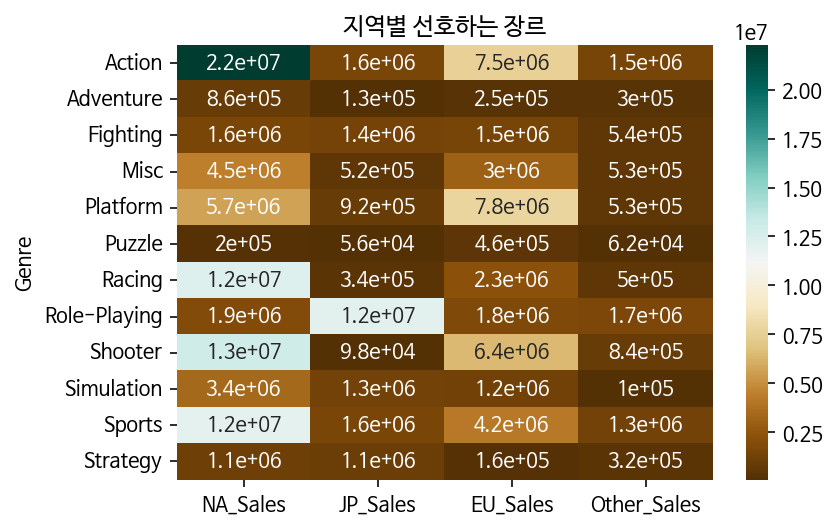

In [446]:
sns.heatmap(df_genre, annot=True, cmap='BrBG')

plt.title('지역별 선호하는 장르', fontsize=12)

plt.show()

녹색이 짙을 수록 더 많은 관계가 있고, 하늘 색에 가까울수록 적은 관계를 가진다고 볼 수 있다.



*   북미 : 액션, 레이싱, 슈터게임, 스포츠가 수요가 있음
*   일본 : 롤플레이잉이 수요가 많음
*   유럽국가 : 액션, 플랫폼, 슈터게임, 스포츠가 높다
*   기타 : 골고루 분포






*   막대그래프로 국가별 선호장르 자세히 보기



In [509]:
df_genre1=df_genre1.sort_values(by='Total_Sales', ascending=False)
df_genre1

,Genre,NA_Sales,JP_Sales,EU_Sales,Other_Sales,Total_Sales
0,Action,22307280.0,1595160.0,7536610.0,1522650.0,32961700.0
8,Shooter,12992050.0,98120.0,6424110.0,841120.0,20355400.0
10,Sports,11995920.0,1583310.0,4207130.0,1291190.0,19077550.0
7,Role-Playing,1917160.0,12111150.0,1791480.0,1675110.0,17494900.0
6,Racing,12292750.0,336040.0,2272980.0,496090.0,15397860.0
4,Platform,5660160.0,919740.0,7813010.0,530970.0,14923880.0
3,Misc,4480640.0,523760.0,3025330.0,532180.0,8561910.0
9,Simulation,3418190.0,1342260.0,1221880.0,101250.0,6083580.0
2,Fighting,1578990.0,1425800.0,1518480.0,535650.0,5058920.0
11,Strategy,1116780.0,1088060.0,164700.0,320920.0,2690460.0


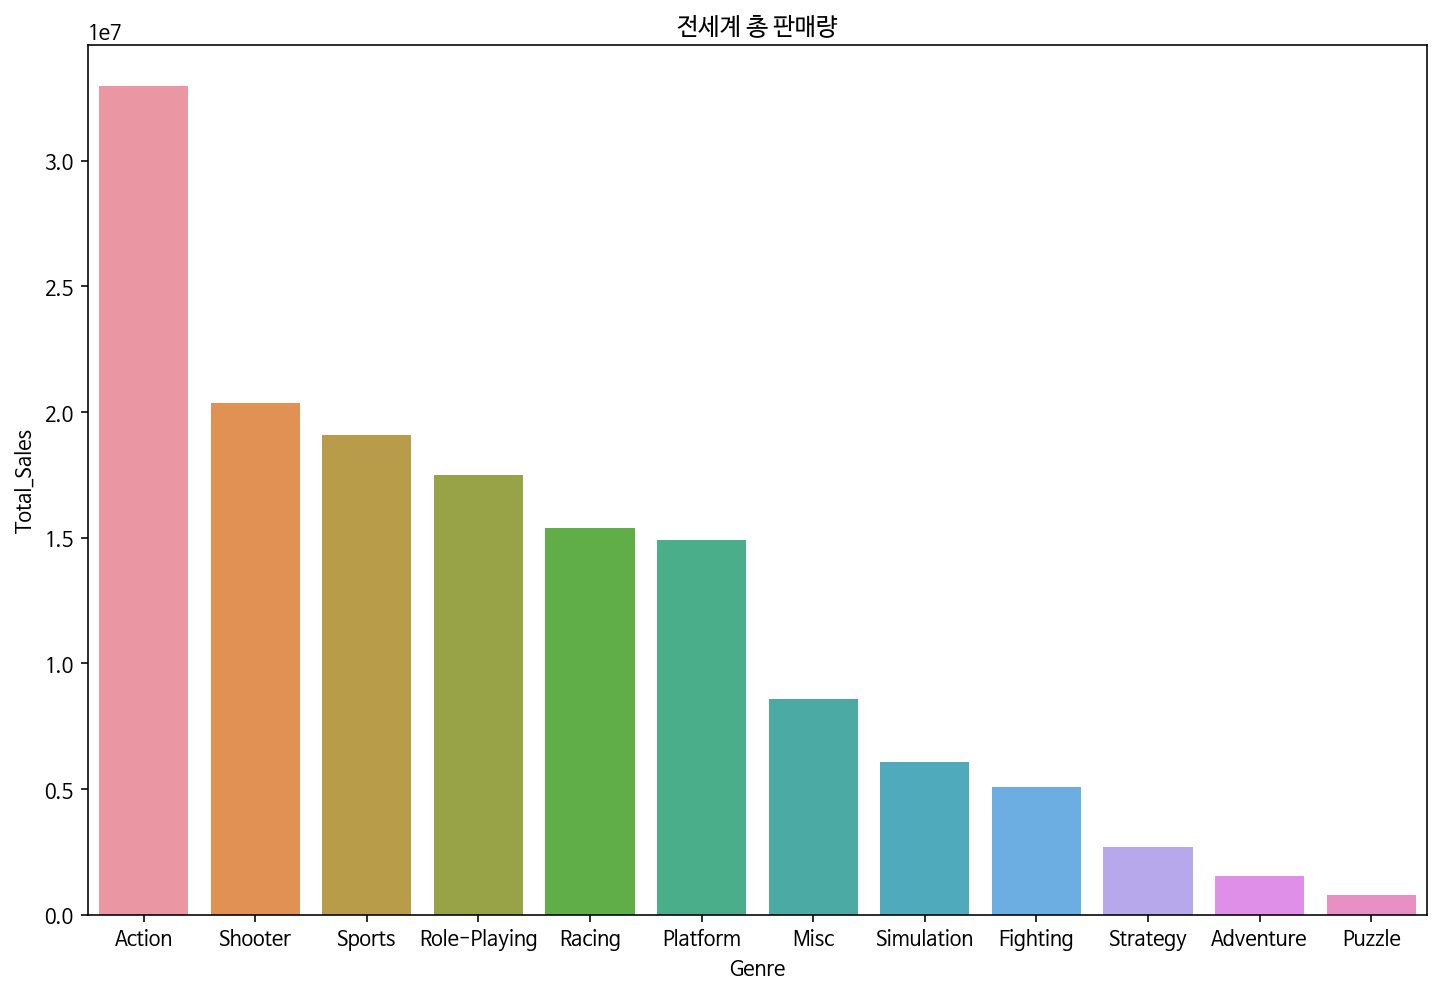

In [510]:
plt.figure(figsize = (12,8))
sns.barplot(x='Genre',y='Total_Sales', data = df_genre1)
plt.title('전세계 총 판매량', fontsize=12)
plt.show()

In [478]:
df_genre11=df_genre1.sort_values(by='NA_Sales', ascending=False)
df_genre11

,Genre,NA_Sales,JP_Sales,EU_Sales,Other_Sales,Total_Sales
0,Action,22307280.0,1595160.0,7536610.0,1522650.0,32961700.0
8,Shooter,12992050.0,98120.0,6424110.0,841120.0,20355400.0
6,Racing,12292750.0,336040.0,2272980.0,496090.0,15397860.0
10,Sports,11995920.0,1583310.0,4207130.0,1291190.0,19077550.0
4,Platform,5660160.0,919740.0,7813010.0,530970.0,14923880.0
3,Misc,4480640.0,523760.0,3025330.0,532180.0,8561910.0
9,Simulation,3418190.0,1342260.0,1221880.0,101250.0,6083580.0
7,Role-Playing,1917160.0,12111150.0,1791480.0,1675110.0,17494900.0
2,Fighting,1578990.0,1425800.0,1518480.0,535650.0,5058920.0
11,Strategy,1116780.0,1088060.0,164700.0,320920.0,2690460.0


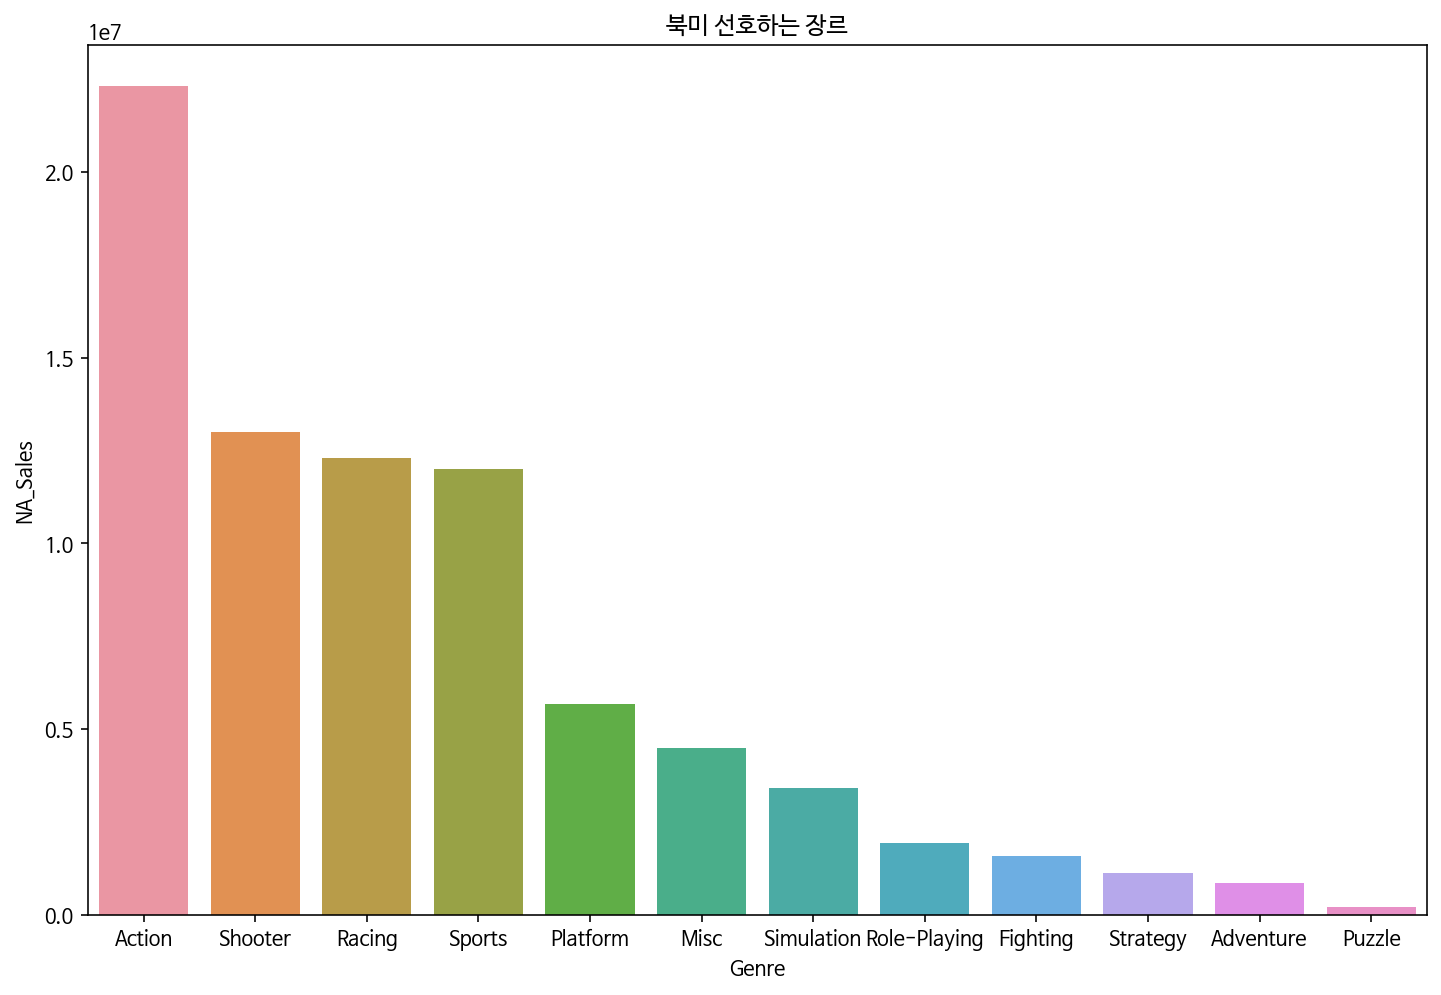

In [479]:
plt.figure(figsize = (12,8))
sns.barplot(x='Genre',y='NA_Sales', data = df_genre11)
plt.title('북미 선호하는 장르', fontsize=12)
plt.show()

In [480]:
df_genre12=df_genre1.sort_values(by='JP_Sales', ascending=False)
df_genre12

,Genre,NA_Sales,JP_Sales,EU_Sales,Other_Sales,Total_Sales
7,Role-Playing,1917160.0,12111150.0,1791480.0,1675110.0,17494900.0
0,Action,22307280.0,1595160.0,7536610.0,1522650.0,32961700.0
10,Sports,11995920.0,1583310.0,4207130.0,1291190.0,19077550.0
2,Fighting,1578990.0,1425800.0,1518480.0,535650.0,5058920.0
9,Simulation,3418190.0,1342260.0,1221880.0,101250.0,6083580.0
11,Strategy,1116780.0,1088060.0,164700.0,320920.0,2690460.0
4,Platform,5660160.0,919740.0,7813010.0,530970.0,14923880.0
3,Misc,4480640.0,523760.0,3025330.0,532180.0,8561910.0
6,Racing,12292750.0,336040.0,2272980.0,496090.0,15397860.0
1,Adventure,861030.0,131790.0,253470.0,296420.0,1542710.0


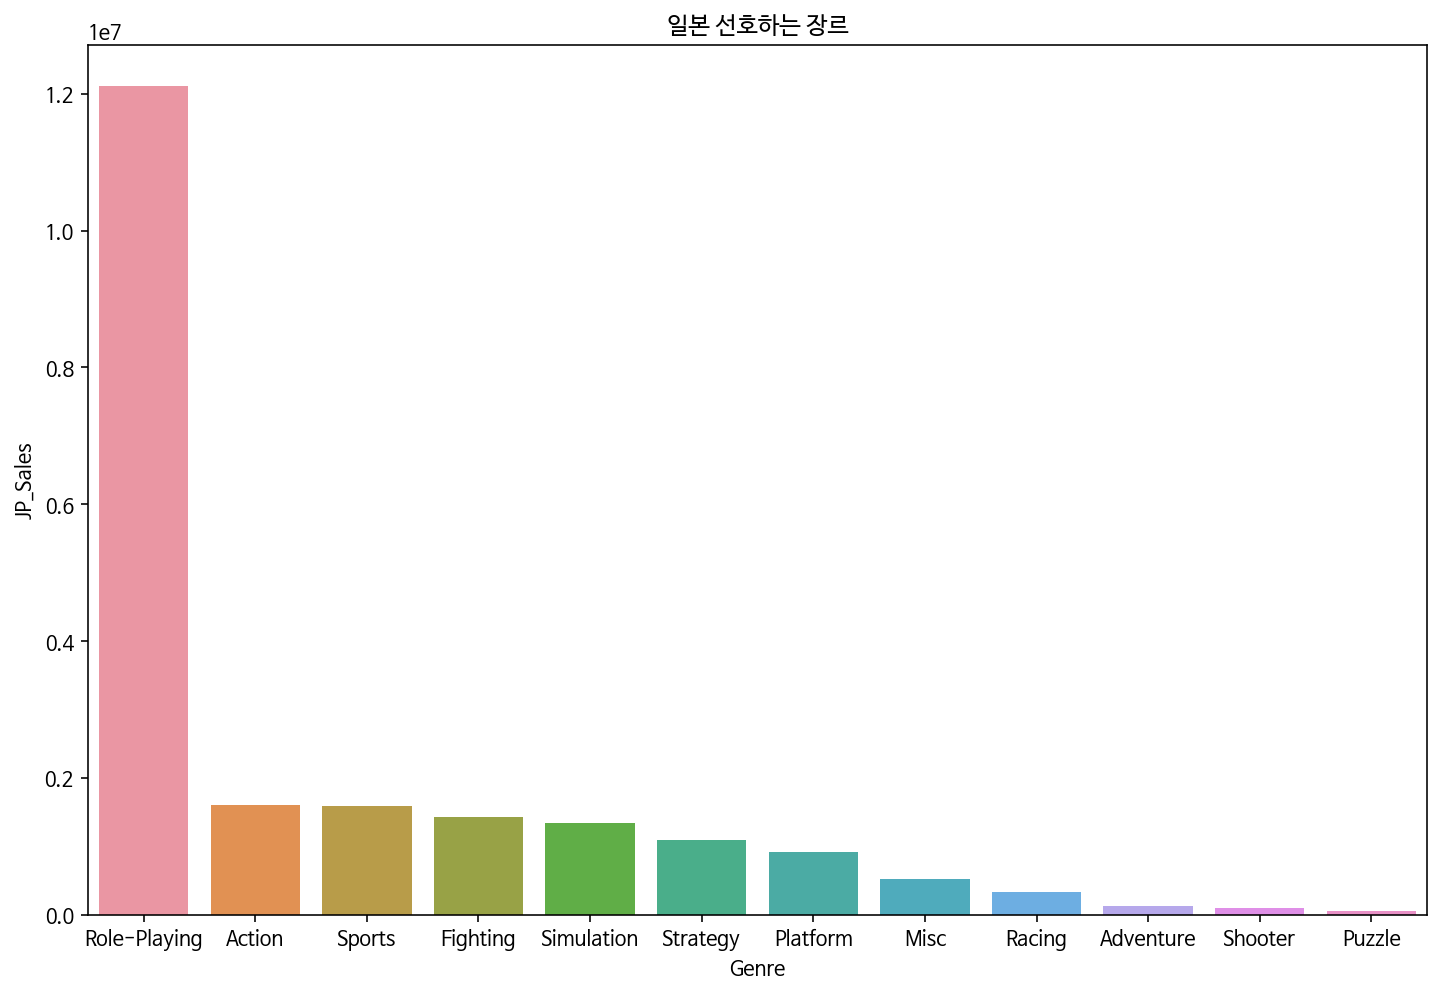

In [481]:
plt.figure(figsize = (12,8))
sns.barplot(x='Genre',y='JP_Sales', data = df_genre12)
plt.title('일본 선호하는 장르', fontsize=12)
plt.show()

In [482]:
df_genre13=df_genre1.sort_values(by='EU_Sales', ascending=False)
df_genre13

,Genre,NA_Sales,JP_Sales,EU_Sales,Other_Sales,Total_Sales
4,Platform,5660160.0,919740.0,7813010.0,530970.0,14923880.0
0,Action,22307280.0,1595160.0,7536610.0,1522650.0,32961700.0
8,Shooter,12992050.0,98120.0,6424110.0,841120.0,20355400.0
10,Sports,11995920.0,1583310.0,4207130.0,1291190.0,19077550.0
3,Misc,4480640.0,523760.0,3025330.0,532180.0,8561910.0
6,Racing,12292750.0,336040.0,2272980.0,496090.0,15397860.0
7,Role-Playing,1917160.0,12111150.0,1791480.0,1675110.0,17494900.0
2,Fighting,1578990.0,1425800.0,1518480.0,535650.0,5058920.0
9,Simulation,3418190.0,1342260.0,1221880.0,101250.0,6083580.0
5,Puzzle,201500.0,56240.0,460060.0,62390.0,780190.0


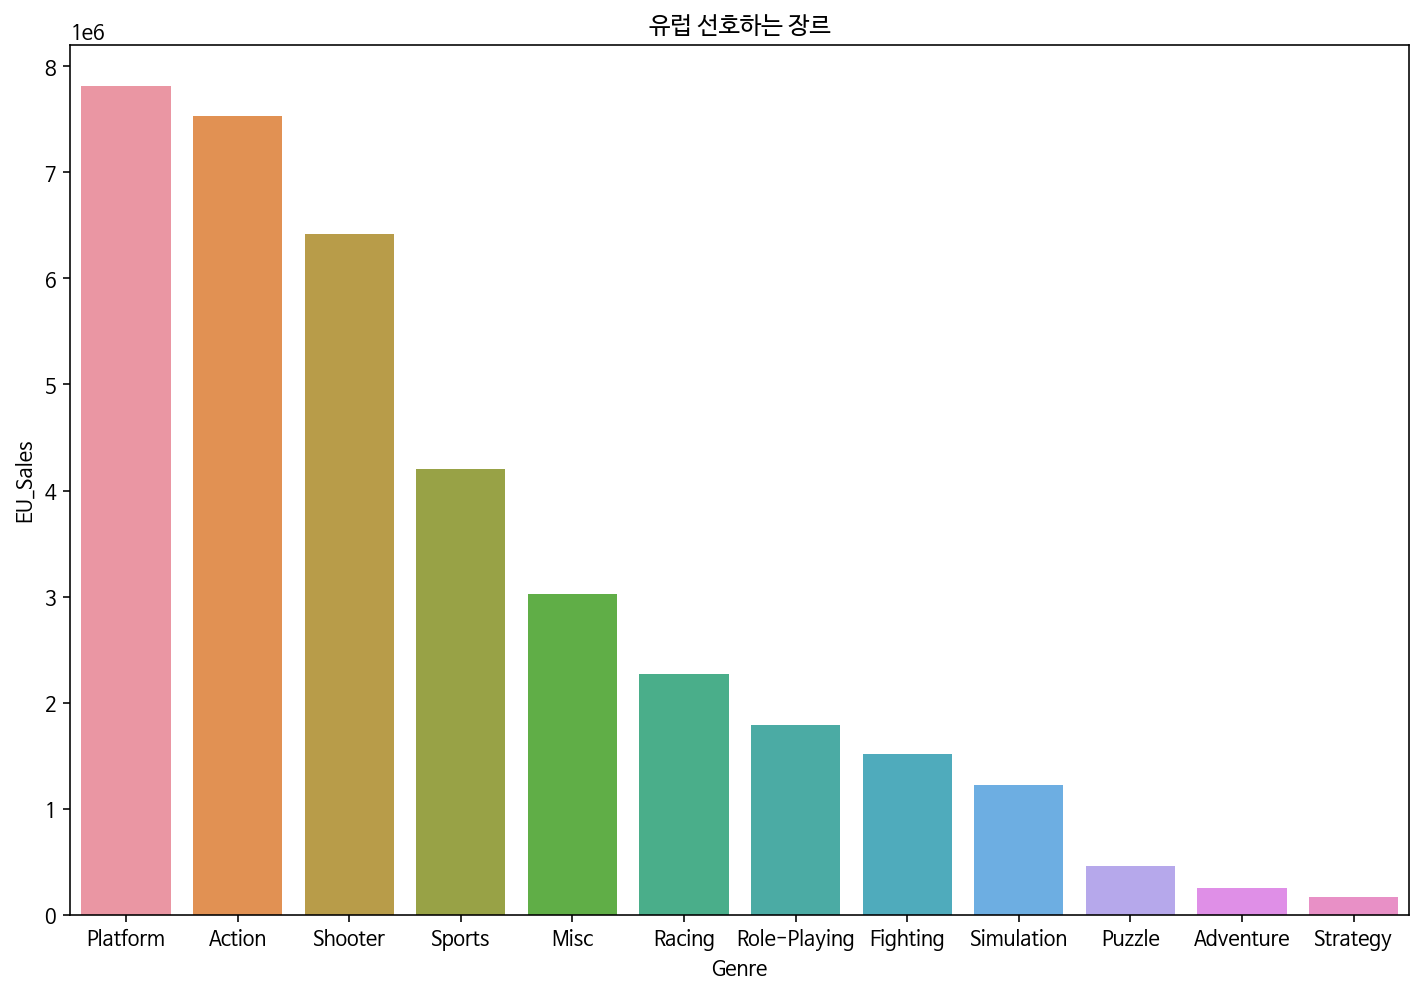

In [483]:
plt.figure(figsize = (12,8))
sns.barplot(x='Genre',y='EU_Sales', data = df_genre13)
plt.title('유럽 선호하는 장르', fontsize=12)
plt.show()

In [484]:
df_genre14=df_genre1.sort_values(by='Other_Sales', ascending=False)
df_genre14

,Genre,NA_Sales,JP_Sales,EU_Sales,Other_Sales,Total_Sales
7,Role-Playing,1917160.0,12111150.0,1791480.0,1675110.0,17494900.0
0,Action,22307280.0,1595160.0,7536610.0,1522650.0,32961700.0
10,Sports,11995920.0,1583310.0,4207130.0,1291190.0,19077550.0
8,Shooter,12992050.0,98120.0,6424110.0,841120.0,20355400.0
2,Fighting,1578990.0,1425800.0,1518480.0,535650.0,5058920.0
3,Misc,4480640.0,523760.0,3025330.0,532180.0,8561910.0
4,Platform,5660160.0,919740.0,7813010.0,530970.0,14923880.0
6,Racing,12292750.0,336040.0,2272980.0,496090.0,15397860.0
11,Strategy,1116780.0,1088060.0,164700.0,320920.0,2690460.0
1,Adventure,861030.0,131790.0,253470.0,296420.0,1542710.0


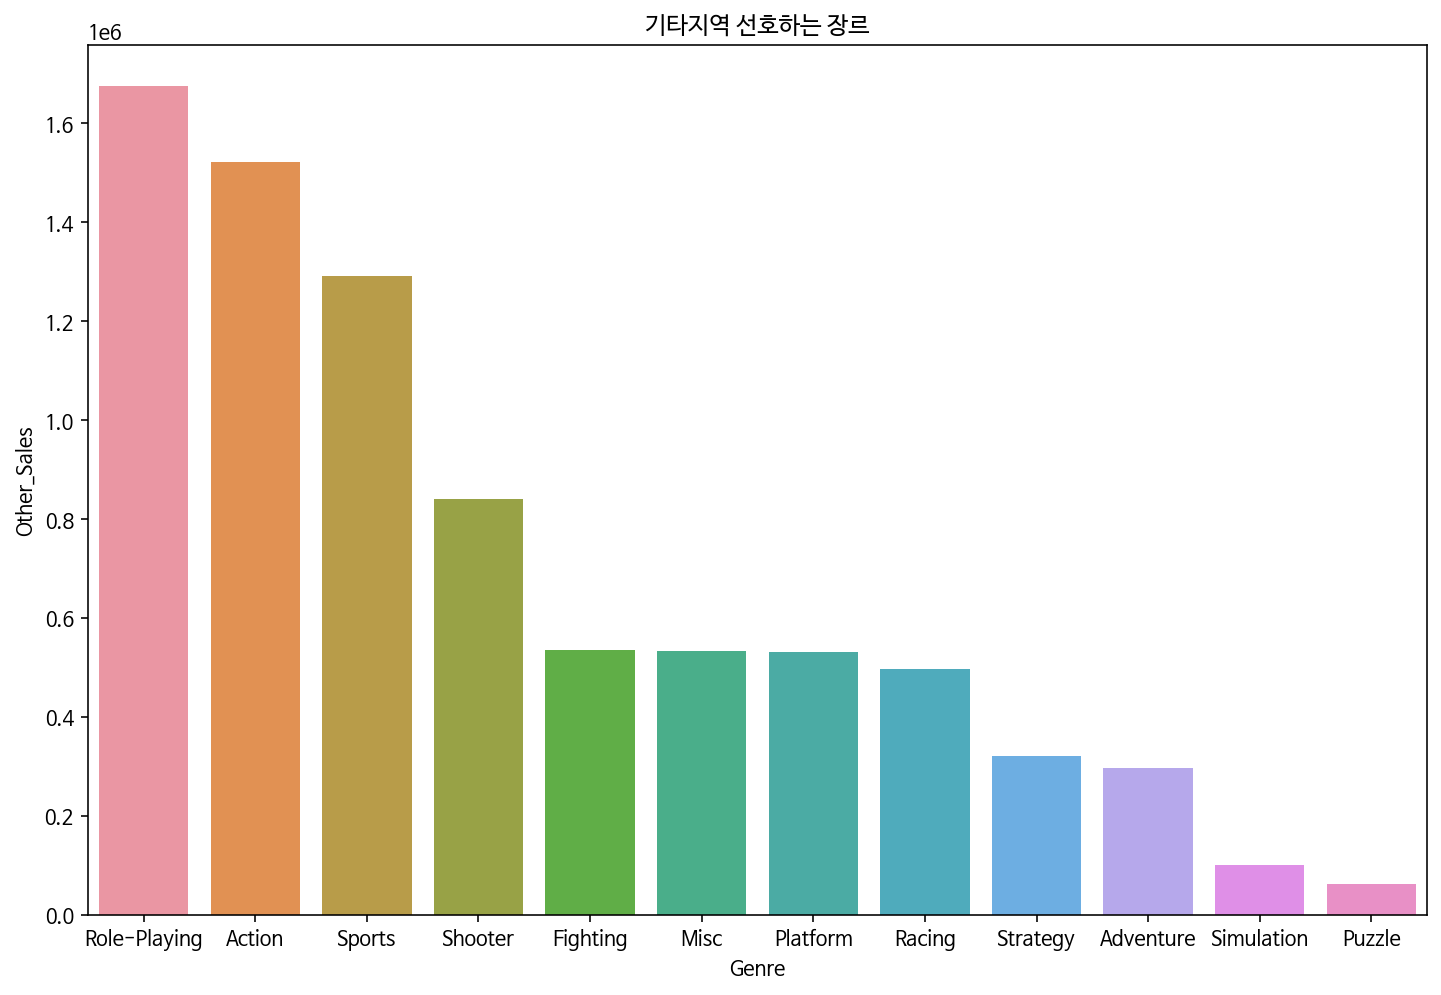

In [485]:
plt.figure(figsize = (12,8))
sns.barplot(x='Genre',y='Other_Sales', data = df_genre14)
plt.title('기타지역 선호하는 장르', fontsize=12)
plt.show()


*  북미 : 액션, 슈터, 레이싱 ,스포츠

*  일본 : 롤플레잉

*  유럽 : 플랫폼, 액션, 슈터, 스포츠

*  기타 : 롤플레잉, 액션, 스포츠, 슈터



*   퍼즐, 시뮬, 어드벤처 등은 인기가 별로 없다









# 3.   연도별 게임 트렌드가 있을까?





*   Year의 값들을 알맞은 값으로 변환


In [495]:
df['Year'].value_counts()

2009    1428
2008    1423
2010    1253
2007    1195
2011    1133
2006    1005
2005     934
2002     826
2003     774
2004     740
2012     652
2015     611
2014     580
2013     545
2001     480
1998     377
2000     348
2016     342
1999     336
1997     289
1996     262
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1984      14
1985      14
1980       8
2017       3
2020       1
Name: Year, dtype: int64

연도의 22이하를 2000년도를 의미하므로 앞에 20을 

*   연도의 22이하를 2000년도를 의미하므로 앞에 20을 추가

*   연도의 80이상을 1900년대 의미하니까 앞에 19추가


In [493]:
correct_year = list(df[(df['Year'] < 100)].index)

for i in correct_year:
    if df['Year'].iloc[i] <= 22 :
        df['Year'].iloc[i] = df['Year'].iloc[i] + 2000
    
    elif df['Year'].iloc[i] >= 80 :
        df['Year'].iloc[i] = df['Year'].iloc[i] + 1900

df['Year'] = df['Year'].astype(int)

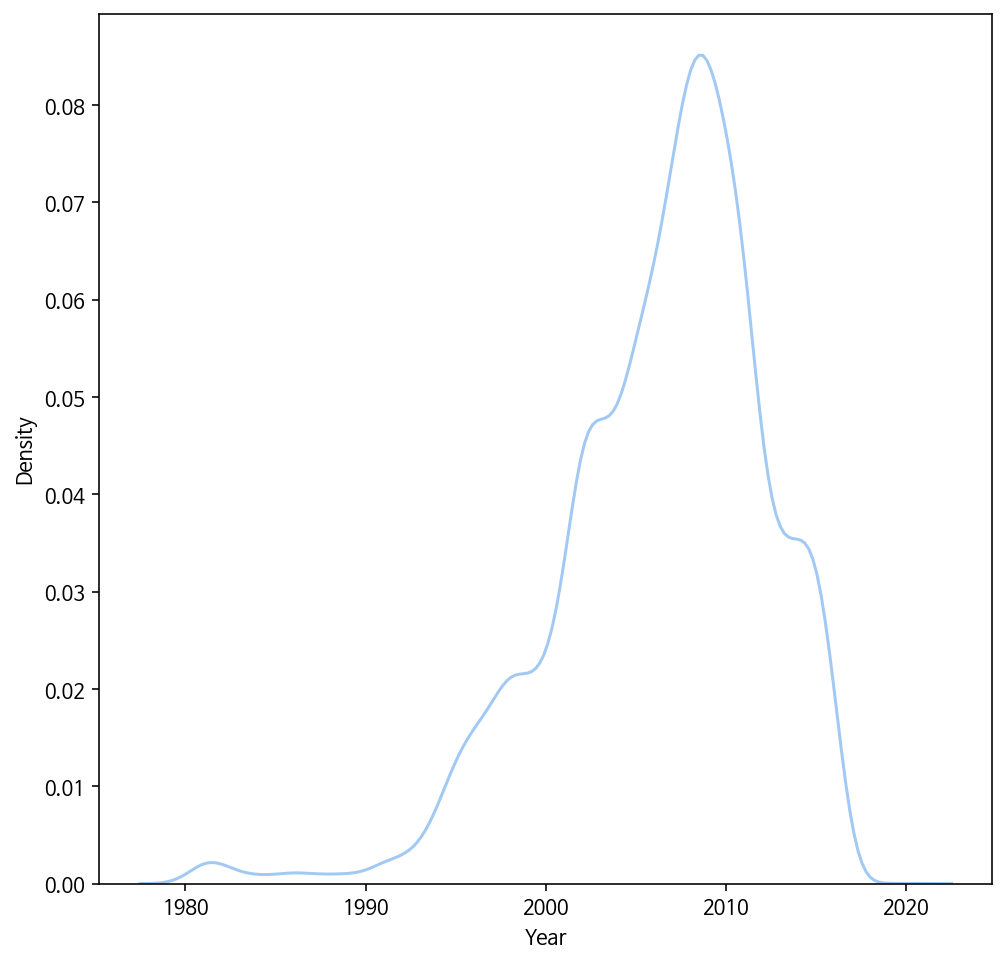

In [494]:
f, ax = plt.subplots(1, 1, figsize=(8,8))
sns.kdeplot('Year', data=df)
plt.show()

*   귀무가설 : 연도와 게임 트랜드는 관련이 없을 것이다.
*   대립가설 : 연도와 게임 트렌드는 상관관계가 있을 것이다. 


In [496]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups,Multiplatform
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40.0,0.0,0.0,0.0,40.0,Portable,True
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170.0,0.0,0.0,10.0,180.0,Console,False
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.0,0.0,20.0,0.0,20.0,Portable,False
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40.0,0.0,0.0,0.0,40.0,Portable,False
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120.0,90.0,0.0,40.0,250.0,Console,True
...,...,...,...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,150.0,40.0,0.0,10.0,200.0,Console,True
16237,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,10.0,0.0,0.0,0.0,10.0,Portable,False
16238,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,440.0,190.0,30.0,130.0,790.0,Console,True
16239,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,50.0,50.0,250.0,30.0,380.0,Portable,True


In [497]:
df1 = df.loc[:,'NA_Sales':'Other_Sales']
df2 = df1.sum(axis=1)
df2

0         40.0
1        180.0
2         20.0
3         40.0
4        250.0
         ...  
16236    200.0
16237     10.0
16238    790.0
16239    380.0
16240    170.0
Length: 16241, dtype: float64

In [498]:
df3=df.loc[:,'Year']
df3

0        2008
1        2009
2        2010
3        2010
4        2010
         ... 
16236    2006
16237    2005
16238    2015
16239    2013
16240    1996
Name: Year, Length: 16241, dtype: int64

In [499]:
df4=pd.concat([df3,df2],axis=1)
df4.tail()

,Year,0
16236,2006,200.0
16237,2005,10.0
16238,2015,790.0
16239,2013,380.0
16240,1996,170.0


In [500]:
df4['Year'].astype(int)
df5=df4.groupby('Year',as_index=False).sum()
df5.head(10)

,Year,0
0,1980,10880.0
1,1981,145570.0
2,1982,28880.0
3,1983,16800.0
4,1984,50350.0
5,1985,513490.0
6,1986,37080.0
7,1987,21700.0
8,1988,237020.0
9,1989,133390.0


In [501]:
df6=df5.rename(columns={0:'Total_Sales'})
df6.head()

,Year,Total_Sales
0,1980,10880.0
1,1981,145570.0
2,1982,28880.0
3,1983,16800.0
4,1984,50350.0


In [502]:
from scipy.stats import chisquare

result = chisquare(df6['Total_Sales'],axis=None)
result

Power_divergenceResult(statistic=205821040.6730451, pvalue=0.0)



*   P-Value가 0.05보다 작으므로 귀무가설 기각
*   연도와 게임트렌드는 어느정도 상관관계가 있다




In [503]:
df_country = df.loc[:,['Year','NA_Sales','JP_Sales','EU_Sales','Other_Sales']]
df_country = df_country.groupby('Year',as_index=False).sum()
df_country['Total_sale'] = df_country[['NA_Sales','JP_Sales','EU_Sales','Other_Sales']].sum(axis=1)
df_country##year를 기준으로 합함

,Year,NA_Sales,JP_Sales,EU_Sales,Other_Sales,Total_sale
0,1980,10130.0,0.0,640.0,110.0,10880.0
1,1981,33400.0,0.0,111850.0,320.0,145570.0
2,1982,26920.0,0.0,1650.0,310.0,28880.0
3,1983,7760.0,8100.0,800.0,140.0,16800.0
4,1984,33280.0,14270.0,2100.0,700.0,50350.0
5,1985,493270.0,14560.0,4740.0,920.0,513490.0
6,1986,12500.0,19810.0,2840.0,1930.0,37080.0
7,1987,8460.0,11630.0,1410.0,200.0,21700.0
8,1988,23870.0,15760.0,6590.0,190800.0,237020.0
9,1989,105090.0,18360.0,8440.0,1500.0,133390.0


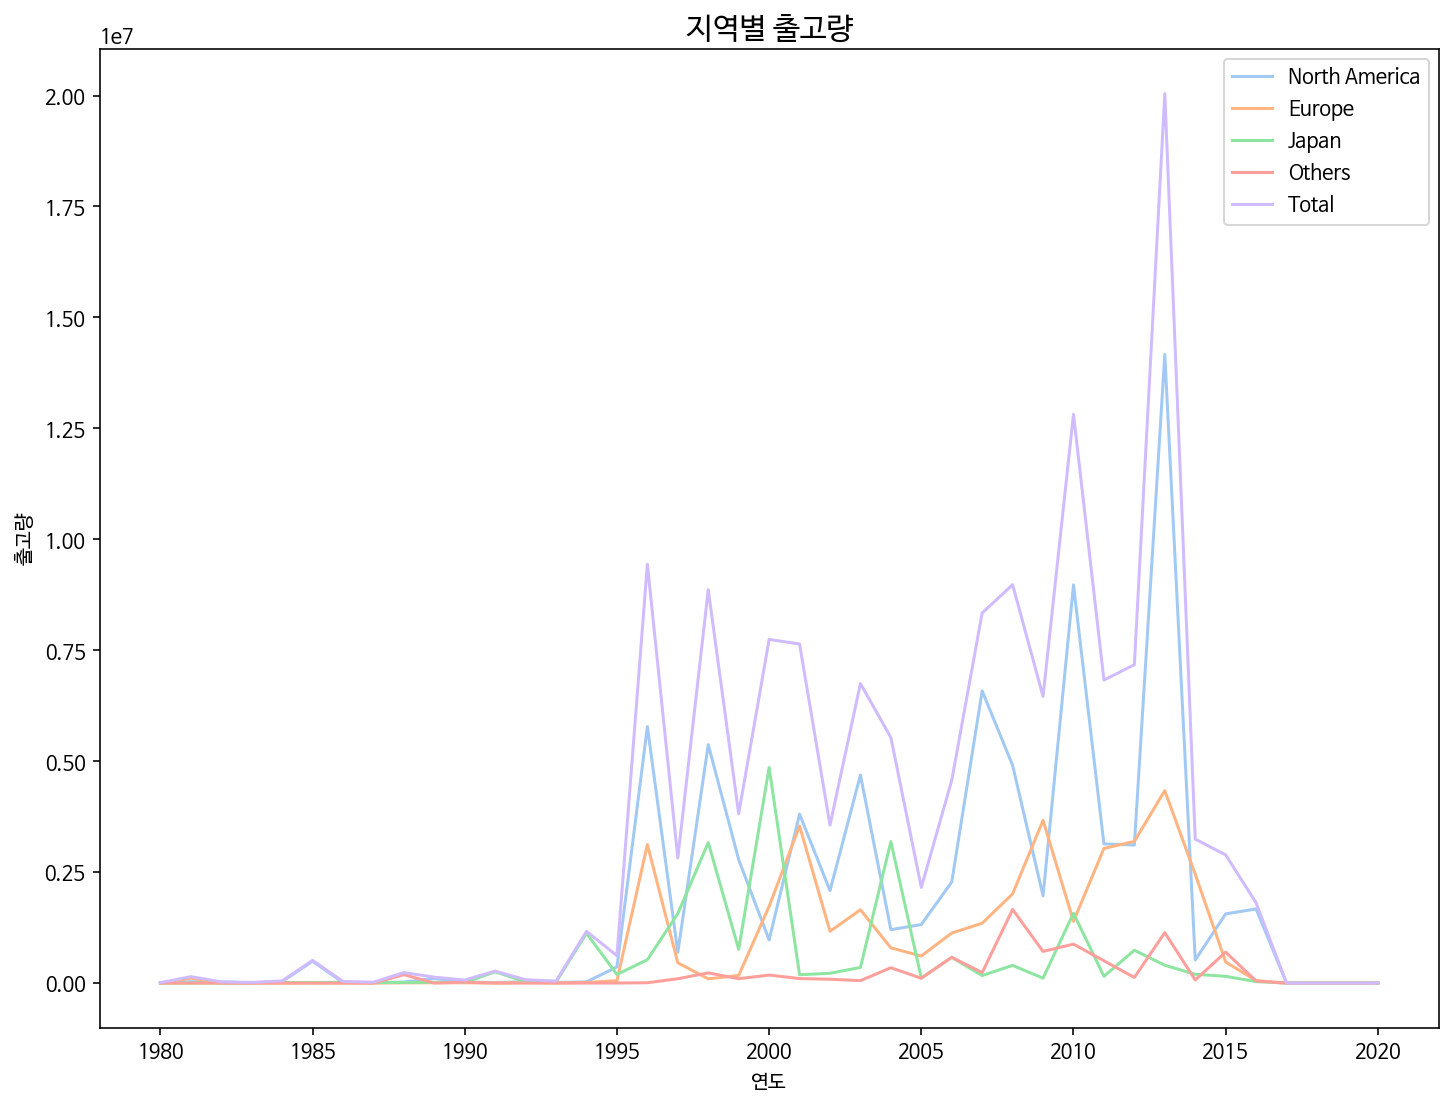

In [504]:
plt.rcParams["figure.figsize"] = (12,9)
sns.set_palette("pastel")
sns.lineplot(df_country["Year"],df_country['NA_Sales'],label='North America',alpha = 1)
sns.lineplot(df_country["Year"],df_country['EU_Sales'],label='Europe',alpha = 1)
sns.lineplot(df_country["Year"],df_country['JP_Sales'],label='Japan',alpha = 1)
sns.lineplot(df_country["Year"],df_country['Other_Sales'],label='Others',alpha = 1)
sns.lineplot(df_country["Year"],df_country['Total_sale'],label='Total',alpha = 1)

plt.xlabel("연도")
plt.ylabel("출고량")
plt.title("지역별 출고량", fontsize=15)

plt.show()



*   연도별 총 판매량은 증가하다 감소하다를 반복하면서 2005년에 최소치를 기록하다 점점 증가한다. 2015년 이후로는 데이터가 없어 정확한 값을 알 수 없다.
*   북미권의 시장이 크다는 것을 알 수 있었고, 1990년 후반에서 2000년 초반에는 유럽과 일본의 판매량이 크다는 것을 확인할 수 있었다.
*   2005년 이후로 일본의 판매량 감소





In [505]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups,Multiplatform
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40.0,0.0,0.0,0.0,40.0,Portable,True
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170.0,0.0,0.0,10.0,180.0,Console,False
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.0,0.0,20.0,0.0,20.0,Portable,False
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40.0,0.0,0.0,0.0,40.0,Portable,False
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120.0,90.0,0.0,40.0,250.0,Console,True
...,...,...,...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,150.0,40.0,0.0,10.0,200.0,Console,True
16237,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,10.0,0.0,0.0,0.0,10.0,Portable,False
16238,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,440.0,190.0,30.0,130.0,790.0,Console,True
16239,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,50.0,50.0,250.0,30.0,380.0,Portable,True


In [506]:
year_list = []
genre_list = []
sale_list = []

year_genre =  df.groupby(['Year','Genre']).sum()['Total_Sales'].reset_index()

for i in range(1980, 2018) :
  year_genre1 = year_genre[year_genre['Year'] == i].sort_values(by='Total_Sales',ascending=False).reset_index(drop=True)
  best_genre = year_genre1.loc[0, 'Genre']
  best_genre_sale = year_genre1.loc[0, 'Total_Sales']

  year_list.append(i)
  genre_list.append(best_genre)
  sale_list.append(best_genre_sale)

 
df_year_genre = pd.DataFrame((zip(year_list, genre_list, sale_list)), columns = ['Year', 'Genre', 'Total_Sales'])
df_year_genre

,Year,Genre,Total_Sales
0,1980,Shooter,7070.0
1,1981,Action,124680.0
2,1982,Puzzle,10040.0
3,1983,Platform,6930.0
4,1984,Shooter,31100.0
5,1985,Platform,502710.0
6,1986,Action,13740.0
7,1987,Fighting,5420.0
8,1988,Platform,217540.0
9,1989,Puzzle,97690.0


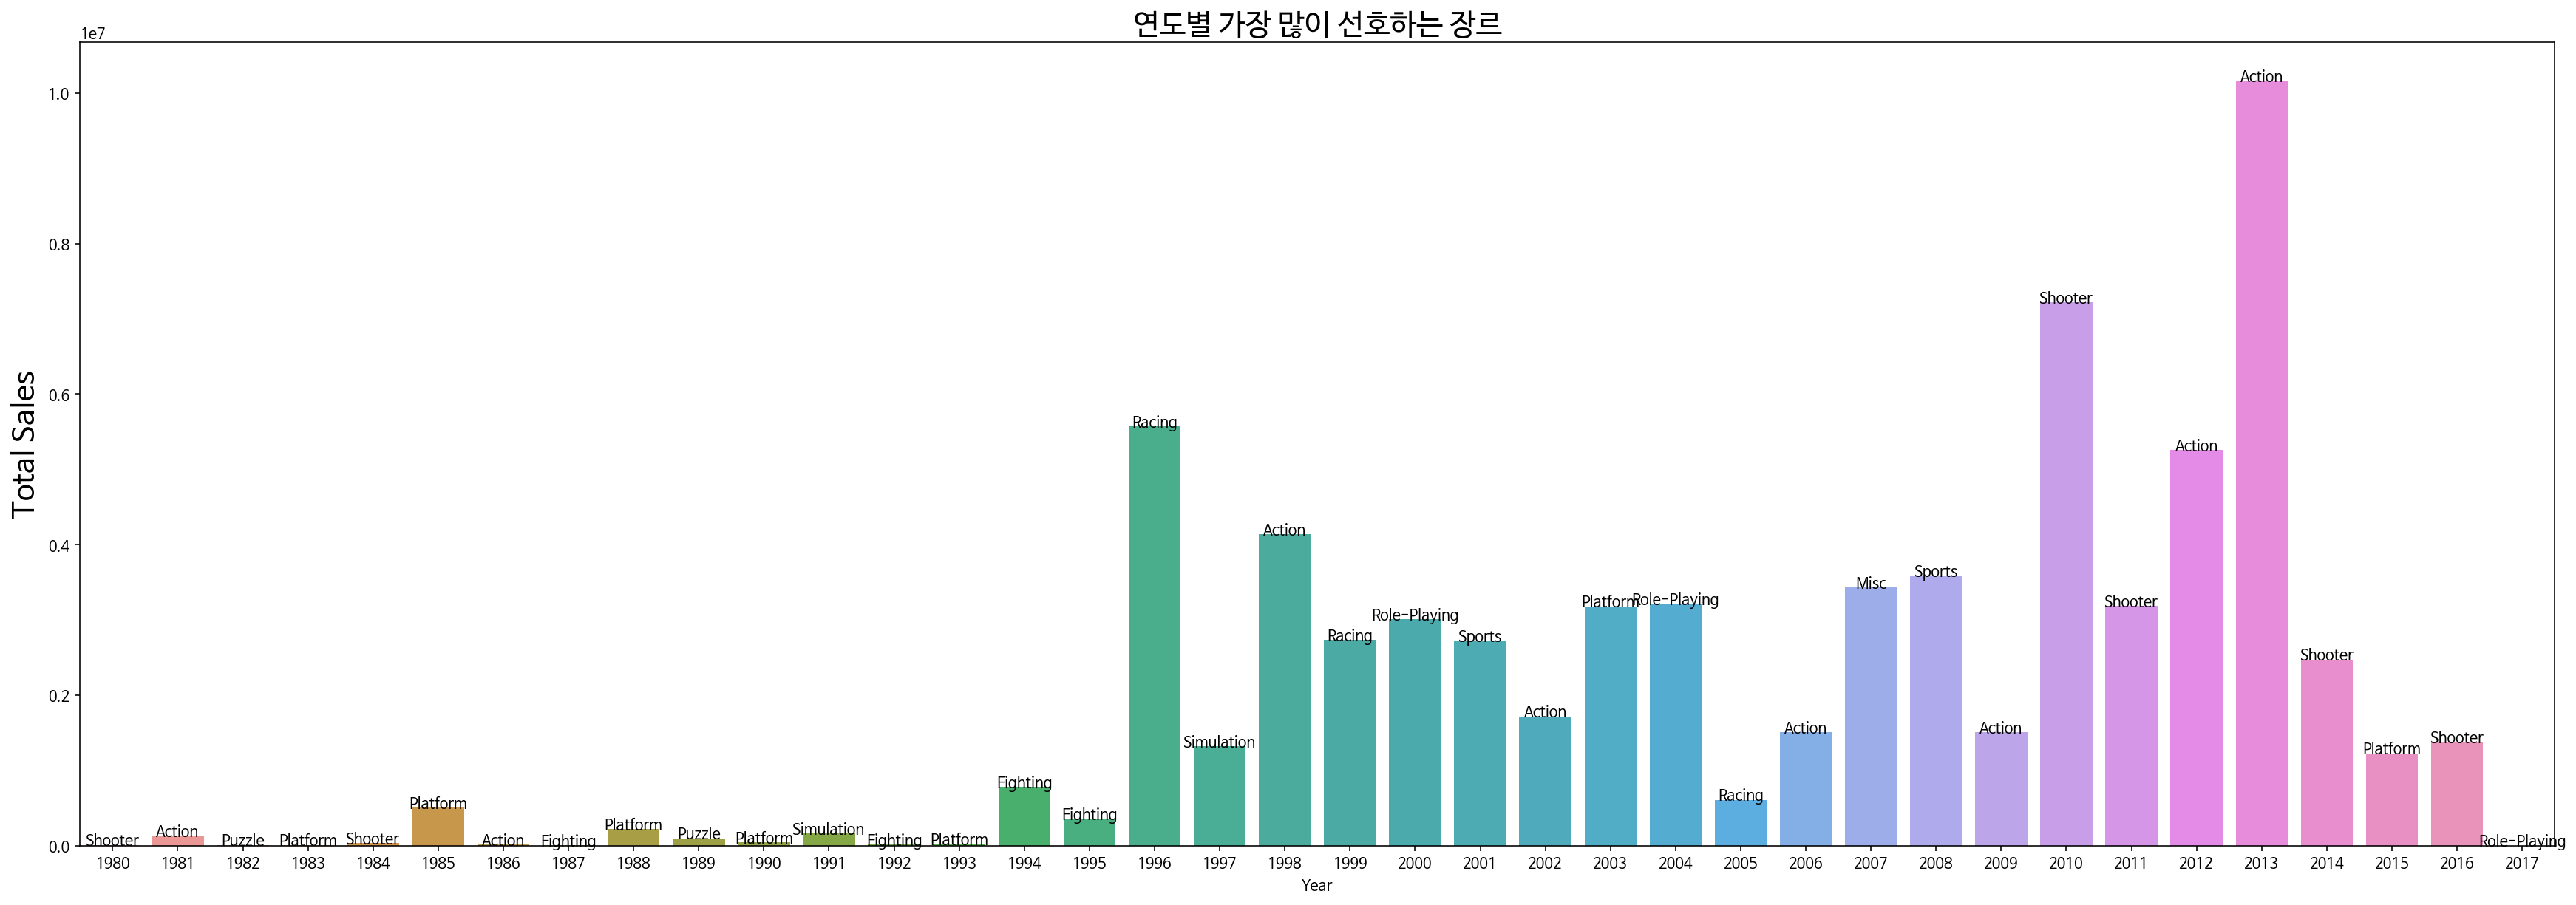

In [507]:
fig, ax = plt.subplots(figsize=(30, 10))
bar = sns.barplot(x='Year', y='Total_Sales', data=df_year_genre)
for index, row in df_year_genre.iterrows():
    plt.text(index , row.Total_Sales, str(row.Genre), color='black', ha="center", size=10)
plt.ylabel('Total Sales', fontsize = 20)
plt.title('연도별 가장 많이 선호하는 장르', fontsize=20)
plt.show()

In [508]:
df_year_genre['Genre'].value_counts()

Action          8
Platform        7
Shooter         6
Fighting        4
Racing          3
Role-Playing    3
Puzzle          2
Simulation      2
Sports          2
Misc            1
Name: Genre, dtype: int64

그래프를 보고 추측할 수 있는 것은 인터넷이 발달 되지 않고 단순히 컴퓨터가 할 수 있는 게임은 퍼즐, 격투, 시뮬 등 인기가 없는 게임을 주로 선호 했던 것을 알 수 있고, 그 이후 일부 해에는 스포츠, 레이싱 장르의 출고량이 많은 것을 보아 선호 되었다는 것을 알 수 있다. 그 후 액션과 슈터 게임의 선호도가 높았다는 것을 알 수 있다.

# 4.   출고량의 높은 게임에 대한 분석 및 시각화 

In [511]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16241 non-null  object 
 1   Platform         16241 non-null  object 
 2   Year             16241 non-null  int64  
 3   Genre            16241 non-null  object 
 4   Publisher        16241 non-null  object 
 5   NA_Sales         16241 non-null  float64
 6   EU_Sales         16241 non-null  float64
 7   JP_Sales         16241 non-null  float64
 8   Other_Sales      16241 non-null  float64
 9   Total_Sales      16241 non-null  float64
 10  Platform_Groups  16241 non-null  object 
 11  Multiplatform    16241 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(5)
memory usage: 1.4+ MB


In [512]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups,Multiplatform
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40.0,0.0,0.0,0.0,40.0,Portable,True
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170.0,0.0,0.0,10.0,180.0,Console,False
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.0,0.0,20.0,0.0,20.0,Portable,False
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40.0,0.0,0.0,0.0,40.0,Portable,False
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120.0,90.0,0.0,40.0,250.0,Console,True




1.   전체 출고량 기준 게임별 상위 10개만 추출
2.   트리맵을 통해 비교해보기



In [513]:
df_total10=df.groupby(['Name']).count()##전체 출고량 기준 게임별 상위 10개만 추출
df_total = df_total10.sort_values(by='Total_Sales',ascending=False)
df_total.head(10)

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups,Multiplatform
Name,,,,,,,,,,,
Need for Speed: Most Wanted,12,12,12,12,12,12,12,12,12,12,12
LEGO Marvel Super Heroes,9,9,9,9,9,9,9,9,9,9,9
FIFA 14,9,9,9,9,9,9,9,9,9,9,9
Ratatouille,9,9,9,9,9,9,9,9,9,9,9
Angry Birds Star Wars,8,8,8,8,8,8,8,8,8,8,8
Cars,8,8,8,8,8,8,8,8,8,8,8
Terraria,8,8,8,8,8,8,8,8,8,8,8
LEGO Star Wars II: The Original Trilogy,8,8,8,8,8,8,8,8,8,8,8
LEGO Jurassic World,8,8,8,8,8,8,8,8,8,8,8



 

*   need for : 레이싱

*   LEGO Marvel Super Heroes : action

*   FIFA 14 : 스포츠

*   Ratatouille : action
*   Angry Birds Star Wars : Strategy


*   Cars : racing


*   Terraria :action


*   LEGO Star Wars II: The Original Trilogy :action

*   LEGO Jurassic World : action

*   FIFA Soccer 13 : sports

In [472]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


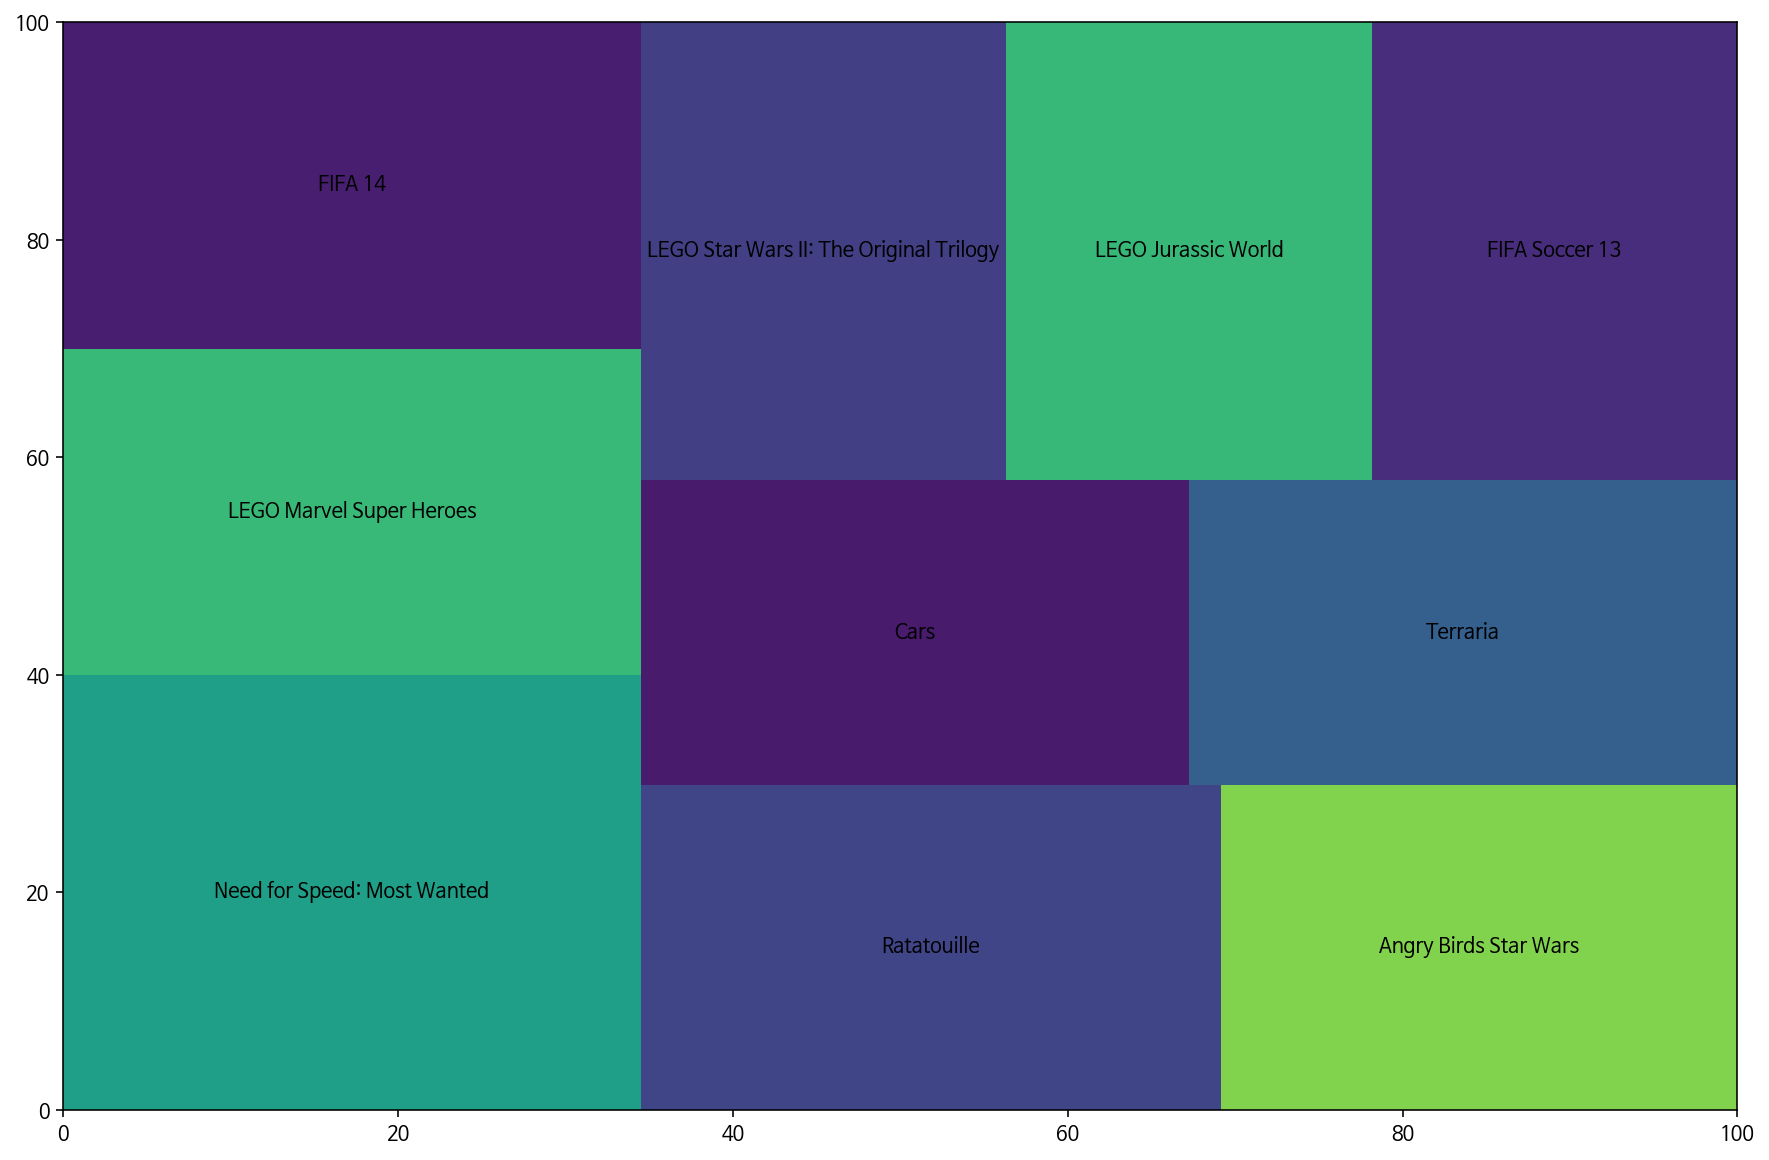

In [514]:
import squarify

plt.figure(figsize=(15,10))

squarify.plot(sizes=df_total['Total_Sales'][:10],
             label=df_total.index.values[:10], alpha=1)

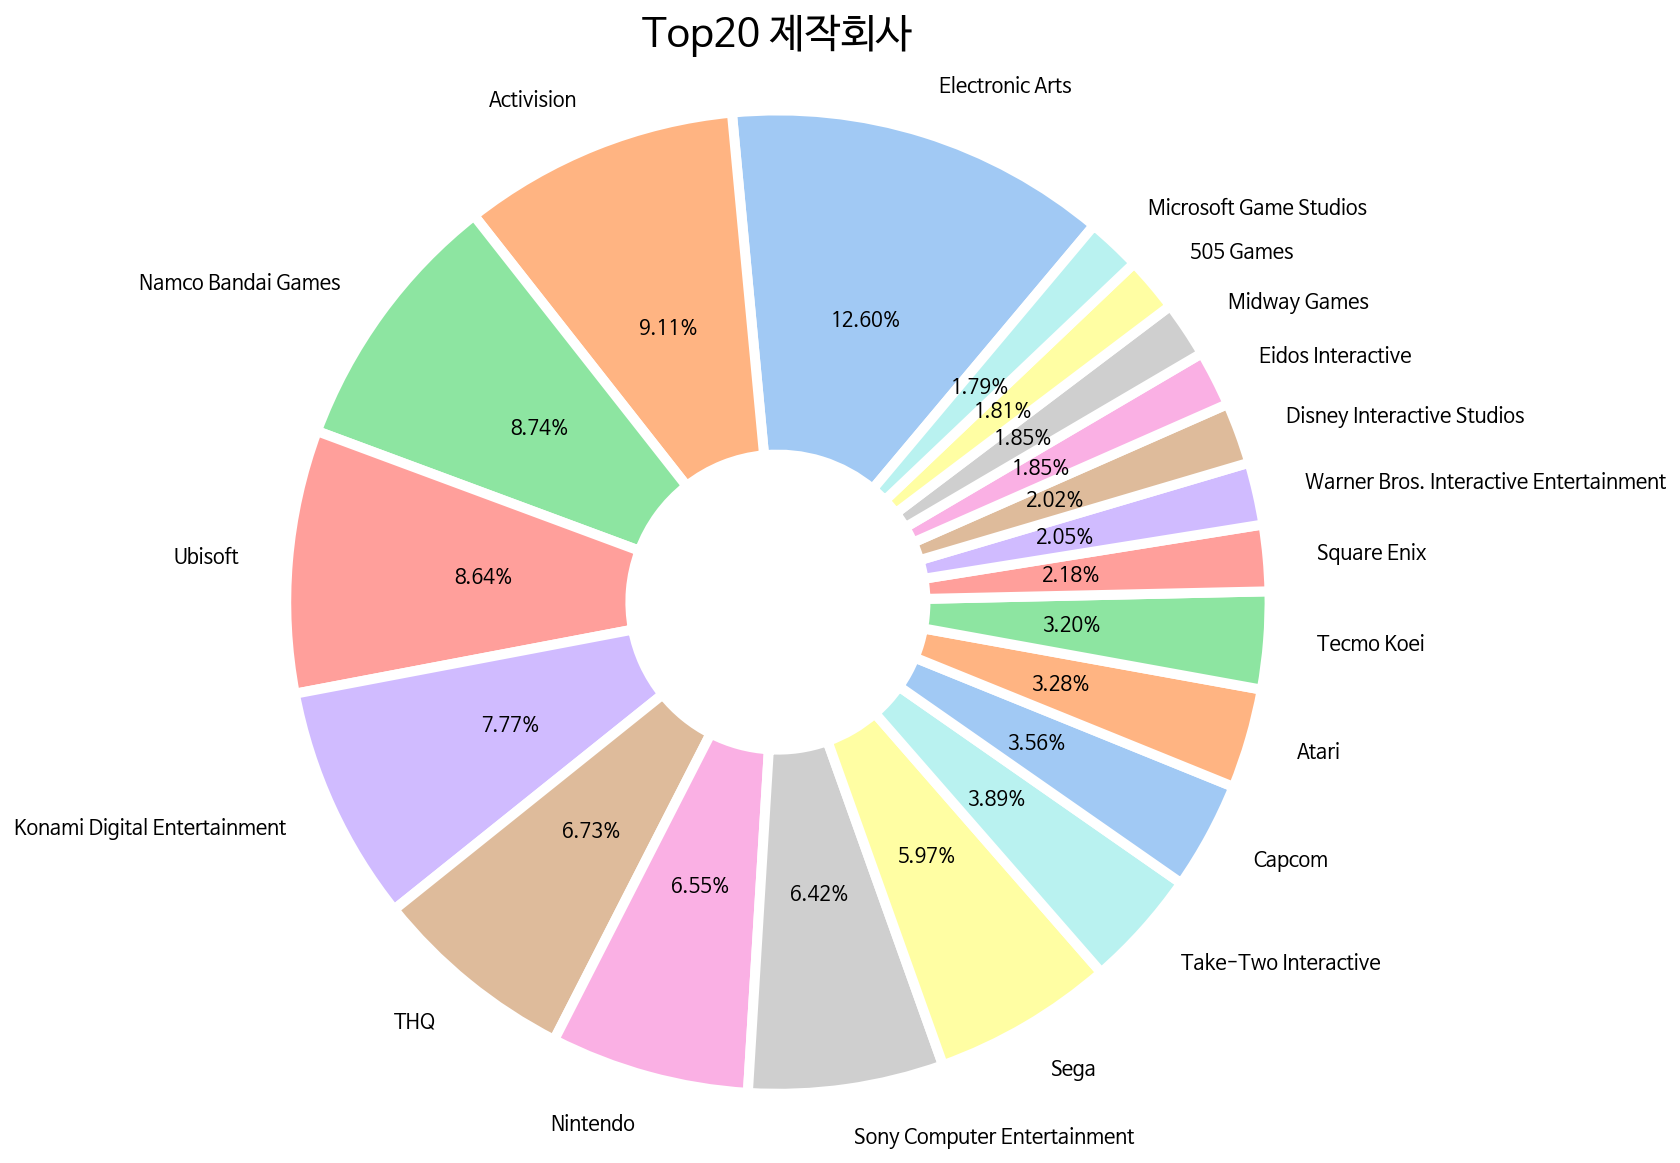

In [526]:
##전체 판매량 기준 회사별 상위 20개만 추출
df_total1=df.groupby(['Publisher']).count()
df_total1 = df_total1.sort_values(by='Total_Sales',ascending=False)
df_total1.head(20)
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
#edgecolor': 'w'데이터 사이 경계선 라인 색깔을 지정합니다.
#linewidth 데이터 사이 경계선 두께를 설정합니다.(클 수록 두꺼움)
plt.figure(figsize=(12,10))
plt.pie(
        df_total1['Total_Sales'][:20], 
        labels=df_total1.index.values[:20],  
        autopct='%1.2f%%', # second decimal place 
        startangle=50,wedgeprops=wedgeprops
) 

plt.axis('equal') #  equal length of X and Y axis
plt.title('Top20 제작회사', fontsize=20)
plt.show()

판매량 1,2위인 회사는 Electronic Arts, Activision 미국회사

*   Electronic Arts : FIFA 시리즈, 심즈 시리즈, 스타워즈 시리즈배급회사
*   Activision : 마블 캐릭터 이용한 히어로 게임, 트랜스포머 캐릭터 이용한 액션게임에 강점, 액션게임인 "콜오브 듀티"가 큰 인기

*   Namco Bandai Games : 일본회사로 나루토,건담,팩맨, 엘든 링, 원피스 등 유명 애니메이션 캐릭터들과 DLC를 필두로 게임을 보급
*   Ubitsoft : 어썌신 크리드, 레인보우 식스, 파크라이 ,저스트 댄스 등 인기 있는 게임을 창조


*   Konami Digital Entertainment :  일본회사,메탈기어 솔리드,슈퍼봄버맨, 위닝일레븐2015 





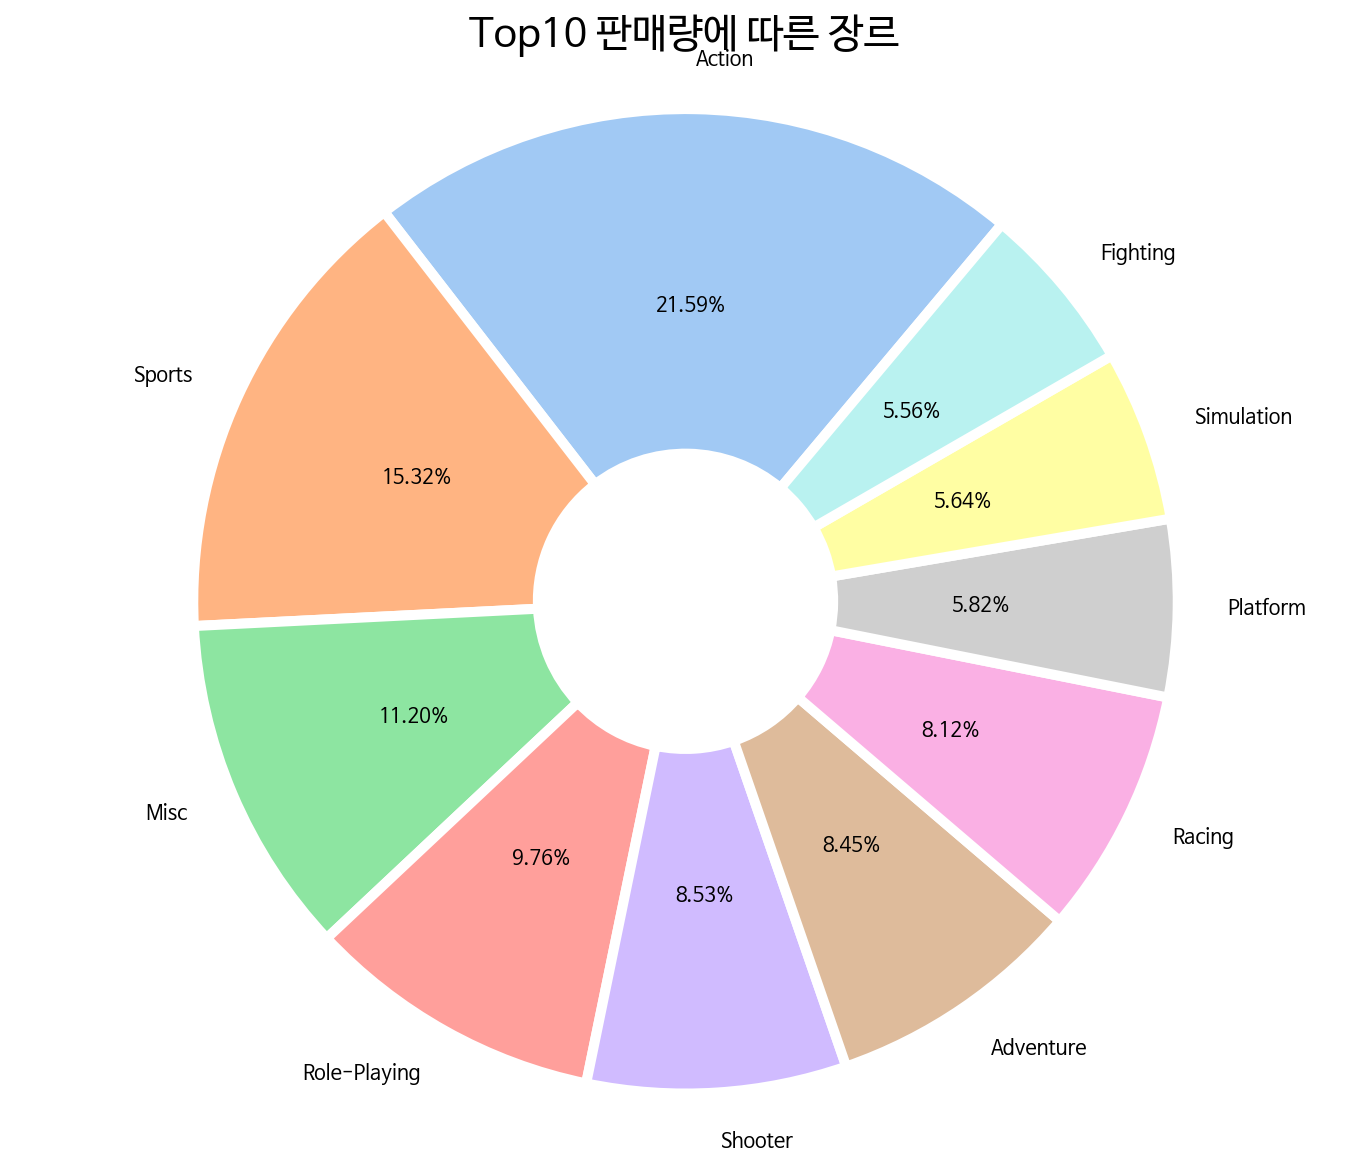

In [525]:
#전체 판매량 기준 장르별 상위 10개 추출
df_total2=df.groupby(['Genre']).count()
df_total2 = df_total2.sort_values(by='Total_Sales',ascending=False)
df_total2.head(20)
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.figure(figsize=(12,10))
plt.pie(
        df_total2['Total_Sales'][:10], 
        labels=df_total2.index.values[:10],  
        autopct='%1.2f%%', # second decimal place 
        startangle=50,wedgeprops=wedgeprops
) 

plt.axis('equal') #  equal length of X and Y axis
plt.title('Top10 판매량에 따른 장르', fontsize=20)
plt.show()


# 5. 결론적으로 다음 분기에 어떤 게임을 설계해야 하는지를 제시하기    
*   플랫폼을 크게 휴대용 기기, 콘솔, PC로 나눈 결과 콘솔이 가장 많이 팔렸다. 
*   게임 시장에서는 북미 지역이 가장 큰 영향력을 끼치는 것을 확인 할 수 있었다. 

*   전세계적으로 Action, Shooter,racing, sport가 판매량이 많았고
판매량 상위권인 회사들을 분석해본결과 Action, Shooter, racing, sprot이 주로 구성 되어있는 게임들이 많았다.

* 다음 시즌에 게임을 만들게 된다면 이영향력을 고려해서 북미지역을 타겟으로 하는 액션, 스포츠, 슈터, 레이싱 등이 혼합된 형태의 게임을 만드는 것을 긍정적으로 검토 해야한다.
*   점유율이 2위인 일본시장을 타깃으로 하면 일본이 가지는 특성을 고려해서 설계를 해야한다.   






# 6. 한계점 및 개선사항


*   시리즈 게임이나 리마스터/리메이크 게임의 경우 판매량에 영향을 끼쳐 게임설계 판단에 영향을 미칠 수 있다
*  게임의 종류에 모바일 게임이 있는데 국내시장에서의 모바일 게임을 개발할 떄 무엇을 고려해야하는지 이 자료로는 알 수 없다.


*  플스게임을 컴퓨터를 통해 스팀으로 할 수 있는데 이것을 어떻게 구분해야 할 지 잘 몰라서 데이터 분석을 하지 못했다. 

